# Model Building

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('ca_covid_data_clean.csv', index_col=0)

In [6]:
df.columns

Index(['cumulative_tests', 'new_tests', 'cumulative_cases',
       'cumulative_deaths', 'new_cases', 'new_deaths',
       'hospitalized_covid_confirmed_patients',
       'hospitalized_suspected_covid_patients', 'icu_covid_confirmed_patients',
       'icu_suspected_covid_patients', 'icu_available_beds',
       'nh_total_resident_cases', 'nh_new_resident_cases',
       'nh_total_resident_deaths', 'nh_total_health_care_worker_cases',
       'nh_new_health_care_worker_cases', 'nh_new_resident_deaths',
       'beds_ready_to_accept_patients', 'patients_in_beds',
       'elderly_cumulative_cases', 'elderly_new_cases',
       'minority_cumulative_cases', 'minority_new_positives'],
      dtype='object')

#### Set up variables and split data into a train and test set

In [7]:
y = df.new_deaths
X = df.drop(['new_deaths', 'cumulative_deaths', 'cumulative_tests', 'cumulative_cases', 'nh_total_resident_cases', 'nh_total_resident_deaths', 'nh_total_health_care_worker_cases', 'elderly_cumulative_cases', 'minority_cumulative_cases'], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

#### Establish baseline multiple linear regression model with initial R-squared and RMSE

In [70]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_reg = reg.predict(X_test)
print('R-squared: ' + str(r2_score(y_test, y_pred_reg)), 'RMSE: ' + str(np.sqrt(mse(y_test, y_pred_reg))))

R-squared: 0.6490231791448677 RMSE: 35.89949726136942


#### Test an elastic net model with preprocessing

In [10]:
steps_elastic = [('scaler', StandardScaler()), ('elastic_net', ElasticNet())]
pipeline_elastic = Pipeline(steps_elastic)
pipeline_elastic.fit(X_train, y_train)
y_pred_elastic = pipeline_elastic.predict(X_test)
print('R-squared: ' + str(r2_score(y_test, y_pred_elastic)), 'RMSE: ' + str(np.sqrt(mse(y_test, y_pred_elastic))))

R-squared: 0.5475714711254744 RMSE: 40.759058168563065


#### Test a random forest regression model and tune hyperparameters to optimize performance

In [69]:
rf = RandomForestRegressor()
params_rf = {'n_estimators': [100, 350, 500], 'max_features': ['log2','auto','sqrt'], 'min_samples_leaf': [1,10,30]}
grid_rf = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv=3)
grid_rf.fit(X_train, y_train)
optimal_rf = grid_rf.best_estimator_
y_pred_rf = optimal_rf.predict(X_test)
print('R-squared: ' + str(r2_score(y_test, y_pred_rf)), 'RMSE: ' + str(np.sqrt(mse(y_test, y_pred_rf))))

R-squared: 0.6817089436824119 RMSE: 34.18702948892998


#### Examine which predictor variables had the strongest effect on the random forest model

In [72]:
pd.Series(data = optimal_rf.feature_importances_, index = X.columns).sort_values(ascending=False)

minority_new_positives                   0.210064
icu_covid_confirmed_patients             0.117414
elderly_new_cases                        0.108288
icu_available_beds                       0.085393
new_tests                                0.083915
hospitalized_suspected_covid_patients    0.069593
icu_suspected_covid_patients             0.049889
new_cases                                0.049350
nh_new_health_care_worker_cases          0.047197
beds_ready_to_accept_patients            0.041107
hospitalized_covid_confirmed_patients    0.040172
nh_new_resident_deaths                   0.034071
patients_in_beds                         0.032249
nh_new_resident_cases                    0.031298
dtype: float64

#### Test a gradient boosting regression model with hyperparameter tuning

In [71]:
gb = GradientBoostingRegressor()
params_gb = {'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 250, 500], 'subsample': [0.25, 0.5, 1.0], 'max_features': ['log2','auto','sqrt'], 'max_depth': [2,3,4]}
grid_gb = GridSearchCV(gb, params_gb, scoring='neg_root_mean_squared_error', cv=3)
grid_gb.fit(X_train, y_train)
optimal_gb = grid_gb.best_estimator_
y_pred_gb = optimal_gb.predict(X_test)
print('R-squared: ' + str(r2_score(y_test, y_pred_gb)), 'RMSE: ' + str(np.sqrt(mse(y_test, y_pred_gb))))

R-squared: 0.7497079740706118 RMSE: 30.316052859199104


#### Examine which predictor variables had the strongest effect on the gradient boosting model

In [73]:
features_gb = pd.Series(data = optimal_gb.feature_importances_, index = X.columns).sort_values(ascending=False)

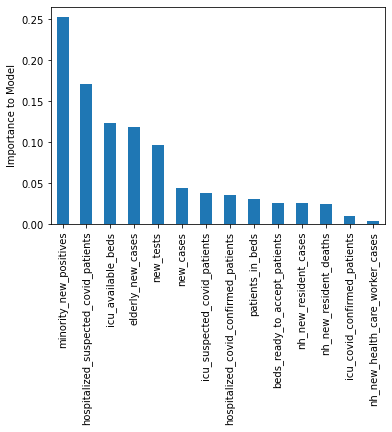

In [74]:
features_gb.plot(kind= 'bar')
plt.ylabel('Importance to Model')
plt.show()